### Utilizando boto3 para processamento de Linguagem Natural 
Neste tutorial iremos utilizar ferramentas de processamento de audio e texto e Linguagem Natural para analisar dados provenientes de vídeos do Youtube. <br>
Os arquivos serão baixados utilizando uma ferramenta de linha de comando chamada [Youtube-DL](https://github.com/ytdl-org/youtube-dl/blob/master/README.md#readme), e iremos utilizar os serviços de NLP oferecidos pela AWS, accessados pela biblioteca [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html).

In [10]:
# Bibliotecas que serão utilizadas ao longo do tutorial
from __future__ import print_function
import boto3
import os
import time
import pandas as pd
import matplotlib as plt
import logging
from botocore.exceptions import ClientError
from datetime import date
import json

%matplotlib inline

#### 1) Baixando arquivos de vídeo do Youtube
O primeiro passo em nosso tutorial é baixar os arquivos de áudio a partir de links de videos específicos selecionados. Para isso usaremos a ferramenta Youtube-DL que pode ser instalada através do ```pip```.

```sudo pip install youtube-dl```<br>
ou<br>
```conda install -c conda-forge youtube-dl```


Para baixar um vídeo qualquer: 

```youtube-dl <video_url>```

Como iremos trabalhar apenas com áudio, podemos usar o parâmetro ```-x``` e ```--audio-format "mp3"``` para baixar somente a parte de áudio do vídeo do Youtube. 

```youtube-dl -x --audio-format "mp3" <video_url>```

#### Lista de Vídeos de selecionados
Serão analisados 5 discursos gravados em vídeo e disponibilizados publicamente no Youtube. Segue a descrição de cada um deles:

A) ["We shall never surrender" de Winston Churchill](https://www.youtube.com/watch?v=s_LncVnecLA)<br>
Esse discurso histórico foi proferido pelo Primeiro Ministro Britânico Winston Churchill no dia 4 junho de 1940. Nele, o estadista aborda a situação crítica no qual se encontrava os aliados frente a invasão nazista na França e da batalha de Dunkirk. 

B) ["Tear down this wall", Ronald Reagan](https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s)<br>
No dia 12 de junho de 1987, Ronald Reagan, o presidente americano em exercício na época faz um discurso ao portão de Brandeburgo na Alemanha na presença do líder soviético Mikhail Gorbachev, fazendo um apelo em prol da liberdade dos Europeus vivendo sobre a repressão da União Soviética, e pede ao fim que o muro que dividia país fosse colocado abaixo.

C) ["I have a dream", Martin Luther King](https://www.youtube.com/watch?v=vP4iY1TtS3s&t=42s)<br>
Discurso do pastor Martin Luther King em 28 de agosto de 1963 durante a Marcha de Washington é considerado um dos mais importantes da história americana. Nele, Martin Luther King fala sobre a necessidade de se combater o racismo presente nos EUA na época e conclama uma coexistência harmoniosa em brancos e negros no futuro.

D) ["It's harder to be kind than clever", Jeff Bezos](https://www.youtube.com/watch?v=uvzkujQFlxQ)<br>
Discurso do CEO da Amazon na formatura da Universidade de Princeton em 2010 fala sobre experiências pessoais na construção de seu caráter e decisões importantes na carreira. No momento alto do discurso Bezos diz que é mais difícil ser bom do que ser inteligente, mostrando um lado afetuoso de um dos grandes líderes de empresa da história.

E) ["Make good Art", Neil Gaiman](https://www.youtube.com/watch?v=plWexCID-kA)<br>
Neil Gaiman coloca toda sua genialidade literária em um discurso desafiador na formatura da universidade de Artes da Filadélfia em 2012 e desafia os formandos a "fazerem boa arte" com coragem e paixão.

In [14]:
dict_urls_youtube = {
    'churchill': 'https://www.youtube.com/watch?v=s_LncVnecLA',
    'reagan': 'https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s',
    'luther_king': 'https://www.youtube.com/watch?v=vP4iY1TtS3s&t=42s',
    'bezos': 'https://www.youtube.com/watch?v=uvzkujQFlxQ',
    'gaiman': 'https://www.youtube.com/watch?v=plWexCID-kA'}

In [12]:
for url in list(dict_urls_youtube.values()):
    print(f'Baixando arquivo de áudio do link: {url}')
    os.system(f'youtube-dl -x --audio-format "mp3" {url}')

Baixando arquivo de áudio do link: https://www.youtube.com/watch?v=s_LncVnecLA
Baixando arquivo de áudio do link: https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s
Baixando arquivo de áudio do link: https://www.youtube.com/watch?v=vP4iY1TtS3s&t=42s
Baixando arquivo de áudio do link: https://www.youtube.com/watch?v=uvzkujQFlxQ
Baixando arquivo de áudio do link: https://www.youtube.com/watch?v=plWexCID-kA


In [15]:
# Criar um Dataframe para guardar as informações geradas ao longo da análise
df_audio = pd.DataFrame.from_dict(dict_urls_youtube, orient='index', columns=['youtube_urls'])
df_audio

,youtube_urls
churchill,https://www.youtube.com/watch?v=s_LncVnecLA
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s
luther_king,https://www.youtube.com/watch?v=vP4iY1TtS3s&t=42s
bezos,https://www.youtube.com/watch?v=uvzkujQFlxQ
gaiman,https://www.youtube.com/watch?v=plWexCID-kA


In [16]:
# Atribuindo nome do arquivo baixado a cada autor do discurso
for audio_file in os.listdir('.'):
    if 'churchill' in audio_file.lower():
        df_audio.at['churchill','filename'] = audio_file
    elif 'reagan' in audio_file.lower():
        df_audio.at['reagan', 'filename'] = audio_file
    elif 'king' in audio_file.lower():
        df_audio.at['luther_king', 'filename'] = audio_file
    elif 'bezos' in audio_file.lower():
        df_audio.at['bezos', 'filename'] = audio_file
    elif 'gaiman' in audio_file.lower():
        df_audio.at['gaiman', 'filename'] = audio_file

In [17]:
df_audio

,youtube_urls,filename
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,WE SHALL NEVER SURRENDER speech by Winston Chu...
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s,'Berlin Wall' Speech - President Reagan's Addr...
luther_king,https://www.youtube.com/watch?v=vP4iY1TtS3s&t=42s,I Have a Dream speech by Martin Luther King .J...
bezos,https://www.youtube.com/watch?v=uvzkujQFlxQ,Amazon founder Jeff Bezos delivers speech at P...
gaiman,https://www.youtube.com/watch?v=plWexCID-kA,Neil Gaiman 2012 Commencement Speech 'Make Goo...


### Configurando o AWS CLI pelo terminal
Para trabalhar com o boto3, você deve instalar o ```awscli```
```
$ pip install awscli --upgrade --user
```

E em seguida configurá-lo com as suas credenciais da AWS

```
aws configure
```

E definir os seguintes valores:

```
AWS Access Key ID [****************DNYA]: 
AWS Secret Access Key [****************oEG/]: 
Default region name [us-east-1]: 
Default output format [json]:
```

Também podemos configurar as permissões de usuário a AWS usando o *boto3*:

```python
import boto3
 
aws_access_key_id = '<AWS_ACCESS_KEY_ID>'
aws_secret_access_key = '<AWS_SECRET_ACCESS_KEY>'
region_name = 'us-east-1'
 
session = boto3.session.Session(aws_access_key_id=aws_access_key_id,
                                aws_secret_access_key=aws_secret_access_key,
                                region_name=region_name)
```

In [18]:
# Subindo os arquivos para o S3
# Criar um cliente S3
s3 = boto3.client('s3')

# Buscar lista de buckets no S3
response = s3.list_buckets()

# Organizar a resposta em uma lista
buckets = [bucket['Name'] for bucket in response['Buckets']]

for bucket in buckets:
    print(bucket)
#print("Bucket List: %s" % buckets)

aws-deepracer-35d06d75-1bdf-410f-8544-4675a95e89e2
aws-sam-cli-gsg
dnanexus-backup-gsg
elasticbeanstalk-us-east-1-089951219780
grupy-nlp-aws
little-thomas-assets
medium-lambda-tutorial-bucket
regis-media
stackery-assetsbucket-p8b8xq12o1re
udacity-secure-and-pivate-ai-project
vision-pmp


In [19]:
# Criando um novo bucket para subir os arquivos
bucket_name = 'grupy-nlp-aws'
try:
    client_s3 = boto3.client('s3')
    client_s3.create_bucket(Bucket=bucket_name)
except:
    print('Bucket com o mesmo nome já criado.')

In [21]:
# Subindo os arquivos de audio para o bucket s3 criado
for audio_file in df_audio.filename.values:
    print(audio_file)
    client_s3.upload_file(audio_file, bucket_name,  audio_file)

WE SHALL NEVER SURRENDER speech by Winston Churchill (We Shall Fight on the Beaches)-s_LncVnecLA.mp3
'Berlin Wall' Speech - President Reagan's Address at the Brandenburg Gate - 6_12_87-5MDFX-dNtsM.mp3
I Have a Dream speech by Martin Luther King .Jr HD (subtitled) (Remastered)-vP4iY1TtS3s.mp3
Amazon founder Jeff Bezos delivers speech at Princeton University - Engsub-uvzkujQFlxQ.mp3
Neil Gaiman 2012 Commencement Speech 'Make Good Art'-plWexCID-kA.mp3


In [22]:
df_audio

,youtube_urls,filename
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,WE SHALL NEVER SURRENDER speech by Winston Chu...
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s,'Berlin Wall' Speech - President Reagan's Addr...
luther_king,https://www.youtube.com/watch?v=vP4iY1TtS3s&t=42s,I Have a Dream speech by Martin Luther King .J...
bezos,https://www.youtube.com/watch?v=uvzkujQFlxQ,Amazon founder Jeff Bezos delivers speech at P...
gaiman,https://www.youtube.com/watch?v=plWexCID-kA,Neil Gaiman 2012 Commencement Speech 'Make Goo...


In [23]:
# Definir as URLs dos arquivos no S3 em uma nova coluna no Dataframe
for index, row in df_audio.iterrows():
    bucket_location = boto3.client('s3').get_bucket_location(Bucket=bucket_name)
    object_url = f"https://{bucket_name}.s3.amazonaws.com/{row['filename'].replace(' ', '+')}"
    df_audio.at[index, 'url'] = object_url
    print(object_url)

https://grupy-nlp-aws.s3.amazonaws.com/WE+SHALL+NEVER+SURRENDER+speech+by+Winston+Churchill+(We+Shall+Fight+on+the+Beaches)-s_LncVnecLA.mp3
https://grupy-nlp-aws.s3.amazonaws.com/'Berlin+Wall'+Speech+-+President+Reagan's+Address+at+the+Brandenburg+Gate+-+6_12_87-5MDFX-dNtsM.mp3
https://grupy-nlp-aws.s3.amazonaws.com/I+Have+a+Dream+speech+by+Martin+Luther+King+.Jr+HD+(subtitled)+(Remastered)-vP4iY1TtS3s.mp3
https://grupy-nlp-aws.s3.amazonaws.com/Amazon+founder+Jeff+Bezos+delivers+speech+at+Princeton+University+-+Engsub-uvzkujQFlxQ.mp3
https://grupy-nlp-aws.s3.amazonaws.com/Neil+Gaiman+2012+Commencement+Speech+'Make+Good+Art'-plWexCID-kA.mp3


In [24]:
df_audio

,youtube_urls,filename,url
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,WE SHALL NEVER SURRENDER speech by Winston Chu...,https://grupy-nlp-aws.s3.amazonaws.com/WE+SHAL...
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s,'Berlin Wall' Speech - President Reagan's Addr...,https://grupy-nlp-aws.s3.amazonaws.com/'Berlin...
luther_king,https://www.youtube.com/watch?v=vP4iY1TtS3s&t=42s,I Have a Dream speech by Martin Luther King .J...,https://grupy-nlp-aws.s3.amazonaws.com/I+Have+...
bezos,https://www.youtube.com/watch?v=uvzkujQFlxQ,Amazon founder Jeff Bezos delivers speech at P...,https://grupy-nlp-aws.s3.amazonaws.com/Amazon+...
gaiman,https://www.youtube.com/watch?v=plWexCID-kA,Neil Gaiman 2012 Commencement Speech 'Make Goo...,https://grupy-nlp-aws.s3.amazonaws.com/Neil+Ga...


In [26]:
# Definir uma função para disparar o serviço Amazon Transcribe
def start_transcription(bucket, job_name, file_url, wait_process=True):
    client_transcribe = boto3.client('transcribe')
    client_transcribe.start_transcription_job(
        TranscriptionJobName=job_name,
        Media={'MediaFileUri': file_url},
        MediaFormat='mp3',
        LanguageCode='en-US',
        OutputBucketName=bucket)
    if wait_process:
        while True:
            status = client_transcribe.get_transcription_job(TranscriptionJobName=job_name)
            if status['TranscriptionJob']['TranscriptionJobStatus'] in ['COMPLETED', 'FAILED']:
                break
            print("Not ready yet...")
            time.sleep(20)

        print('Transcription finished')
        return status
    

In [25]:
df_audio

,youtube_urls,filename,url
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,WE SHALL NEVER SURRENDER speech by Winston Chu...,https://grupy-nlp-aws.s3.amazonaws.com/WE+SHAL...
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s,'Berlin Wall' Speech - President Reagan's Addr...,https://grupy-nlp-aws.s3.amazonaws.com/'Berlin...
luther_king,https://www.youtube.com/watch?v=vP4iY1TtS3s&t=42s,I Have a Dream speech by Martin Luther King .J...,https://grupy-nlp-aws.s3.amazonaws.com/I+Have+...
bezos,https://www.youtube.com/watch?v=uvzkujQFlxQ,Amazon founder Jeff Bezos delivers speech at P...,https://grupy-nlp-aws.s3.amazonaws.com/Amazon+...
gaiman,https://www.youtube.com/watch?v=plWexCID-kA,Neil Gaiman 2012 Commencement Speech 'Make Goo...,https://grupy-nlp-aws.s3.amazonaws.com/Neil+Ga...


In [27]:
for index, row in df_audio.iterrows():
    print(f'{index}_speech_{today}', row.url)

NameError: name 'today' is not defined

In [29]:
# Definir a data de hoje para usar no nome dos jobs
today = date.today().strftime("%d%m%Y")
var = 'last'
# Iterar pelos arquivos de audio no bucket S3 e disparar os jobs no Transcribe
for index, row in df_audio.iterrows():
    print(f'{index}_speech_{today}_{var}', row.url)
    start_transcription(bucket_name, f'{index}_speech_{today}_{var}', row.url, wait_process=False)
    df_audio.at[index, 'transcription_url'] = f"https://{bucket_name}.s3.amazonaws.com/{index}_speech_{today}_{var}.json"
    df_audio.at[index, 'json_transcription'] = f"{index}_speech_{today}_{var}.json"

churchill_speech_29082019 https://grupy-nlp-aws.s3.amazonaws.com/WE+SHALL+NEVER+SURRENDER+speech+by+Winston+Churchill+(We+Shall+Fight+on+the+Beaches)-s_LncVnecLA.mp3
reagan_speech_29082019 https://grupy-nlp-aws.s3.amazonaws.com/'Berlin+Wall'+Speech+-+President+Reagan's+Address+at+the+Brandenburg+Gate+-+6_12_87-5MDFX-dNtsM.mp3
luther_king_speech_29082019 https://grupy-nlp-aws.s3.amazonaws.com/I+Have+a+Dream+speech+by+Martin+Luther+King+.Jr+HD+(subtitled)+(Remastered)-vP4iY1TtS3s.mp3
bezos_speech_29082019 https://grupy-nlp-aws.s3.amazonaws.com/Amazon+founder+Jeff+Bezos+delivers+speech+at+Princeton+University+-+Engsub-uvzkujQFlxQ.mp3
gaiman_speech_29082019 https://grupy-nlp-aws.s3.amazonaws.com/Neil+Gaiman+2012+Commencement+Speech+'Make+Good+Art'-plWexCID-kA.mp3


In [30]:
df_audio

,youtube_urls,filename,url,transcription_url,json_transcription
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,WE SHALL NEVER SURRENDER speech by Winston Chu...,https://grupy-nlp-aws.s3.amazonaws.com/WE+SHAL...,https://grupy-nlp-aws.s3.amazonaws.com/churchi...,churchill_speech_29082019_last.json
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s,'Berlin Wall' Speech - President Reagan's Addr...,https://grupy-nlp-aws.s3.amazonaws.com/'Berlin...,https://grupy-nlp-aws.s3.amazonaws.com/reagan_...,reagan_speech_29082019_last.json
luther_king,https://www.youtube.com/watch?v=vP4iY1TtS3s&t=42s,I Have a Dream speech by Martin Luther King .J...,https://grupy-nlp-aws.s3.amazonaws.com/I+Have+...,https://grupy-nlp-aws.s3.amazonaws.com/luther_...,luther_king_speech_29082019_last.json
bezos,https://www.youtube.com/watch?v=uvzkujQFlxQ,Amazon founder Jeff Bezos delivers speech at P...,https://grupy-nlp-aws.s3.amazonaws.com/Amazon+...,https://grupy-nlp-aws.s3.amazonaws.com/bezos_s...,bezos_speech_29082019_last.json
gaiman,https://www.youtube.com/watch?v=plWexCID-kA,Neil Gaiman 2012 Commencement Speech 'Make Goo...,https://grupy-nlp-aws.s3.amazonaws.com/Neil+Ga...,https://grupy-nlp-aws.s3.amazonaws.com/gaiman_...,gaiman_speech_29082019_last.json


In [36]:
# Verificar os jobs do Amazon Transcribe que estão com o Status COMPLETED
client_transcribe = boto3.client('transcribe')
response_transcribe = client_transcribe.list_transcription_jobs(
    Status='COMPLETED')
   # Status='IN_PROGRESS')

response_transcribe

{'Status': 'COMPLETED',
 'NextToken': '3/Q22yZ4n/FldYqPp92GoX3ADk9mPfsO3qZo9qhrTcT1AIMpJT1kTo3E1HAYj6CNHbs9w2RWNhpdyVNX6AXq87WJO3tmrjnhME3D8VLKCsKotw3jMJUBWzGWAUjx/PONNqJeda9KqJLMUIh6pprwxVdN47TKNgRLqpxMuJUzl+Xe1Hd9Lx7eg3LzHujCZnsNFrPUf84hA7pvqEoDcfvpaLoD+N3rTrYKtO9RH1x9abd8iLhyugQFwyMn4l4Ab7idr/7/zDRxNIIc7e/X+JhTDUjDs/8pZUDl46HDo4huUkPR2ioblCWsTwxEgG2o5Xn1Mi54uI3EjLeM/gfSQn9fRiKoA65vIt1CKXRfghURJrx3iiT95pvFOMwg05keD1u7nbA8GMHkzwI+W4yVJzenHLWTUUkXaYVJvFUuiq/gQD1r3H/LLsen5wy5I8Yf5wPTdjXXjhW8C8NlXjNlJnsbMXw9WlRXjw7AOr5EGZvC58AuLJ8KiebmP9d70IXbPYiDJOxjliWRlSkfcxZj1vzY60n12JB+t84fbRGDPh/zhZmSzvgDXp3taExoom9/x84IUcrmHPzJ7ouq2sOoB77CD5G9ftoVJRNIBg4FaQTcWWZiad4OVKVIktuBXxUyuyxf7hjzmfdQ94c8VUGJRCrvrUphIL7jAIMyXrwuWUNSeEpjhV1y0xcpIqYqzFbGoXNeTKVmtNaB9vSJ1Ozp3KDVZweY30A5E15RMjpVKcDOzwNBwt2ihHVhxQsqrsXEuGZcPaiiJI9l/IOuznZaf70oIK7vkt4AqB0FyacgNPlXIFhzC+3B6hW0c2bUllSpIgYPzCxN20ieHkZA9kX5DiSSi1xusYaHAtL9QXdNzFGZedG/hi0htx3J23bxHQC+8t8oT5g3asOHTMXOfOjXg=',
 'TranscriptionJobSummaries': [{'Transcripti

In [33]:
client_transcribe = boto3.client('transcribe')
response_transcribe_job = client_transcribe.get_transcription_job(
    TranscriptionJobName= f'churchill_speech_{today}_teste'
)
response_transcribe_job

{'TranscriptionJob': {'TranscriptionJobName': 'churchill_speech_29082019_teste',
  'TranscriptionJobStatus': 'COMPLETED',
  'LanguageCode': 'en-US',
  'MediaSampleRateHertz': 44100,
  'MediaFormat': 'mp3',
  'Media': {'MediaFileUri': 'https://grupy-nlp-aws.s3.amazonaws.com/WE+SHALL+NEVER+SURRENDER+speech+by+Winston+Churchill+(We+Shall+Fight+on+the+Beaches)-s_LncVnecLA.mp3'},
  'Transcript': {'TranscriptFileUri': 'https://s3.amazonaws.com/grupy-nlp-aws/churchill_speech_29082019_teste.json'},
  'CreationTime': datetime.datetime(2019, 8, 29, 10, 43, 45, 323000, tzinfo=tzlocal()),
  'CompletionTime': datetime.datetime(2019, 8, 29, 10, 47, 32, 602000, tzinfo=tzlocal()),
  'Settings': {'ChannelIdentification': False}},
 'ResponseMetadata': {'RequestId': '0c775104-d9e4-46d3-965b-19fe973dc08a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 29 Aug 2019 16:29:31 GMT',
   'x-amzn-requestid': '0c775104-d9e4-46d3-965b-19fe973dc08a',
   'co

In [37]:
df_audio.transcription_url.to_list()

['https://grupy-nlp-aws.s3.amazonaws.com/churchill_speech_29082019_last.json',
 'https://grupy-nlp-aws.s3.amazonaws.com/reagan_speech_29082019_last.json',
 'https://grupy-nlp-aws.s3.amazonaws.com/luther_king_speech_29082019_last.json',
 'https://grupy-nlp-aws.s3.amazonaws.com/bezos_speech_29082019_last.json',
 'https://grupy-nlp-aws.s3.amazonaws.com/gaiman_speech_29082019_last.json']

In [38]:
# Para listar os jobs executados no Amazon Transcribe
transcribe_client = boto3.client('transcribe')
response = transcribe_client.list_transcription_jobs(
    Status='COMPLETED')
response

{'Status': 'COMPLETED',
 'NextToken': '3/Q22yZ4n/FldYqPp92GoX3ADk9mPfsO3qZo9qhrTcT1AIMpJT1kTo3E1HAYj6CNHbs9w2RWNhpdyVNX6AXq87WJO3tmrjnhME3D8VLKCsKotw3jMJUBWzGWAUjx/PONNqJeda9KqJLMUIh6pprwxVdN47TKNgRLqpxMuJUzl+Xe1Hd9Lx7eg3LzHujCZnsNFrPUf84hA7pvqEoDcfvpaLoD+N3rTrYKtO9RH1x9abd8iLhyugQFwyMn4l4Ab7idr/7/zDRxNIIc7e/X+JhTDUjDs/8pZUDl46HDo4huUkPR2ioblCWsTwxEgG2o5Xn1Mi54uI3EjLeM/gfSQn9fRiKoA65vIt1CKXRfghURJrx3iiT95pvFOMwg05keD1u7nbA8GMHkzwI+W4yVJzenHLWTUUkXaYVJvFUuiq/gQD1r3H/LLsen5wy5I8Yf5wPTdjXXjhW8C8NlXjNlJnsbMXw9WlRXjw7AOr5EGZvC58AuLJ8KiebmP9d70IXbPYiDJOxjliWRlSkfcxZj1vzY60n12JB+t84fbRGDPh/zhZmSzvgDXp3taExoom9/x84IUcrmHPzJ7ouq2sOoB77CD5G9ftoVJRNIBg4FaQTcWWZiad4OVKVIktuBXxUyuyxf7hjzmfdQ94c8VUGJRCrvrUphIL7jAIMyXrwuWUNSeEpjhV1y0xcpIqYqzFbGoXNeTKVmtNaB9vSJ1Ozp3KDVZweY30A5E15RMjpVKcDOzwNBwt2ihHVhxQsqrsXEuGZcPaiiJI9l/IOuznZaf70oIK7vkt4AqB0FyacgNPlXIFhzC+3B6hW0c2bUllSpIgYPzCxN20ieHkZA9kX5DiSSi1xusYaHAtL9QXdNzFGZedG/hi0htx3J23bxHQC+8t8oT5g3asOHTMXOfOjXg=',
 'TranscriptionJobSummaries': [{'Transcripti

In [57]:
df_audio

,youtube_urls,filename,url,transcription_url,json_transcription
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,WE SHALL NEVER SURRENDER speech by Winston Chu...,https://grupy-nlp-aws.s3.amazonaws.com/WE+SHAL...,https://grupy-nlp-aws.s3.amazonaws.com/churchi...,churchill_speech_29082019.json
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s,'Berlin Wall' Speech - President Reagan's Addr...,https://grupy-nlp-aws.s3.amazonaws.com/'Berlin...,https://grupy-nlp-aws.s3.amazonaws.com/reagan_...,reagan_speech_29082019.json
luther_king,https://www.youtube.com/watch?v=vP4iY1TtS3s&t=42s,I Have a Dream speech by Martin Luther King .J...,https://grupy-nlp-aws.s3.amazonaws.com/I+Have+...,https://grupy-nlp-aws.s3.amazonaws.com/luther_...,luther_king_speech_29082019.json
bezos,https://www.youtube.com/watch?v=uvzkujQFlxQ,Amazon founder Jeff Bezos delivers speech at P...,https://grupy-nlp-aws.s3.amazonaws.com/Amazon+...,https://grupy-nlp-aws.s3.amazonaws.com/bezos_s...,bezos_speech_29082019.json
gaiman,https://www.youtube.com/watch?v=plWexCID-kA,Neil Gaiman 2012 Commencement Speech 'Make Goo...,https://grupy-nlp-aws.s3.amazonaws.com/Neil+Ga...,https://grupy-nlp-aws.s3.amazonaws.com/gaiman_...,gaiman_speech_29082019.json


In [41]:
# Função para de baixar o texto transcrito de um Json no S3
def get_text_from_json(bucket, key):
    s3 = boto3.client('s3')
    object = s3.get_object(Bucket=bucket, Key=key)
    serializedObject = object['Body'].read()
    data = json.loads(serializedObject)
    return data.get('results').get('transcripts')[0].get('transcript')

In [42]:
def start_comprehend_job(text):
    list_parts = []
    text_for_analysis = ''
    for sentence in text.split('.'):
        current_text = text_for_analysis + f'{sentence}.'

        if len(current_text.encode('utf-8')) > 5000:
            list_parts.append([len(text_for_analysis), text_for_analysis])
            text_for_analysis = f'{sentence}.'

        else:
            text_for_analysis += f'{sentence}.'

    list_parts.append([len(text_for_analysis), text_for_analysis])
    dict_comprehend = {}
    for t_parts in list_parts:
       
        comprehend_client = boto3.client(service_name='comprehend', region_name='us-east-1')
        sentimentData = comprehend_client.detect_sentiment(Text=t_parts[1], LanguageCode='en')
        
        dict_comprehend[t_parts[0]] = sentimentData
        dict_comprehend[t_parts[0]]['ratio'] = t_parts[0]/float(len(text))

    final_dict = {'Positive':0, 'Negative':0, 'Neutral':0, 'Mixed':0}
    list_sentiments = ['Positive', 'Negative', 'Neutral', 'Mixed']
    for sentiment in list_sentiments:
        for key, value in dict_comprehend.items():
            final_dict[sentiment] += value.get('SentimentScore').get(sentiment) * value.get('ratio')
    
    return final_dict

In [44]:
# Gerar a análise de sentimento usando o Amazon Comprehend
for index, row in df_audio.iterrows():
    transcript_text = get_text_from_json(bucket_name, row.json_transcription)
    comprehend_results = start_comprehend_job(transcript_text)
    for k,v in comprehend_results.items():
        df_audio.at[index, k] = v    
    

In [52]:
# Arrendodar os  valores percentuais dos sentimentos 
df_audio =  df_audio.round(2)
df_audio

,youtube_urls,filename,url,transcription_url,json_transcription,Positive,Negative,Neutral,Mixed
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,WE SHALL NEVER SURRENDER speech by Winston Chu...,https://grupy-nlp-aws.s3.amazonaws.com/WE+SHAL...,https://grupy-nlp-aws.s3.amazonaws.com/churchi...,churchill_speech_29082019_last.json,0.28,0.06,0.52,0.13
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s,'Berlin Wall' Speech - President Reagan's Addr...,https://grupy-nlp-aws.s3.amazonaws.com/'Berlin...,https://grupy-nlp-aws.s3.amazonaws.com/reagan_...,reagan_speech_29082019_last.json,0.16,0.02,0.81,0.02
luther_king,https://www.youtube.com/watch?v=vP4iY1TtS3s&t=42s,I Have a Dream speech by Martin Luther King .J...,https://grupy-nlp-aws.s3.amazonaws.com/I+Have+...,https://grupy-nlp-aws.s3.amazonaws.com/luther_...,luther_king_speech_29082019_last.json,0.34,0.01,0.59,0.06
bezos,https://www.youtube.com/watch?v=uvzkujQFlxQ,Amazon founder Jeff Bezos delivers speech at P...,https://grupy-nlp-aws.s3.amazonaws.com/Amazon+...,https://grupy-nlp-aws.s3.amazonaws.com/bezos_s...,bezos_speech_29082019_last.json,0.53,0.02,0.39,0.07
gaiman,https://www.youtube.com/watch?v=plWexCID-kA,Neil Gaiman 2012 Commencement Speech 'Make Goo...,https://grupy-nlp-aws.s3.amazonaws.com/Neil+Ga...,https://grupy-nlp-aws.s3.amazonaws.com/gaiman_...,gaiman_speech_29082019_last.json,0.46,0.15,0.24,0.16


In [25]:
## Visualização do resultado da análise de sentimento dos discursos

In [63]:
df_audio_radar = df_audio[['Positive','Negative','Neutral','Mixed']]

In [55]:
df = df_audio[['Positive', 'Negative', 'Neutral', 'Mixed']]

In [57]:
df['author'] = df.index

/home/gabriel/miniconda3/envs/nlp_aws/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [58]:
df

,Positive,Negative,Neutral,Mixed,author
churchill,0.28,0.06,0.52,0.13,churchill
reagan,0.16,0.02,0.81,0.02,reagan
luther_king,0.34,0.01,0.59,0.06,luther_king
bezos,0.53,0.02,0.39,0.07,bezos
gaiman,0.46,0.15,0.24,0.16,gaiman


In [59]:
df_melt = pd.melt(df, id_vars="author", var_name="sentiment", value_name="sentiment rate")

In [60]:
df_melt

,author,sentiment,sentiment rate
0,churchill,Positive,0.28
1,reagan,Positive,0.16
2,luther_king,Positive,0.34
3,bezos,Positive,0.53
4,gaiman,Positive,0.46
5,churchill,Negative,0.06
6,reagan,Negative,0.02
7,luther_king,Negative,0.01
8,bezos,Negative,0.02
9,gaiman,Negative,0.15


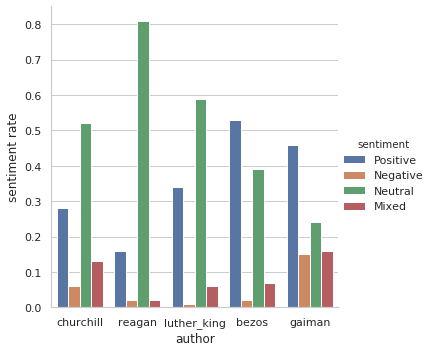

In [66]:
sns_plot = sns.factorplot(x='author', y='sentiment rate', hue='sentiment', data=df_melt, kind='bar')
sns_plot.savefig("barplot.png", dpi=600, orientation ='landscape')

In [69]:
df.T

,churchill,reagan,luther_king,bezos,gaiman
Positive,0.276516,0.156849,0.343839,0.527087,0.461380
Negative,0.064977,0.015465,0.005916,0.015820,0.147436
Neutral,0.523759,0.811257,0.594401,0.390241,0.235781
Mixed,0.134878,0.016495,0.056180,0.066992,0.155467


In [53]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
 
# Set data
df = pd.DataFrame({
'group': ['A','B','C','D'],
'var1': [38, 1.5, 30, 4],
'var2': [29, 10, 9, 34],
'var3': [8, 39, 23, 24],
'var4': [7, 31, 33, 14],
'var5': [28, 15, 32, 14]
})
 
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider( row, title, color):
 
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(2,2,row+1, polar=True, )
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='grey', size=8)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
plt.ylim(0,40)
 
# Ind1
values=df.loc[row].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
ax.fill(angles, values, color=color, alpha=0.4)
 
# Add a title
plt.title(title, size=11, color=color, y=1.1)
 
# ------- PART 2: Apply to all individuals
# initialize the figure
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(df.index))
 
# Loop to plot
for row in range(0, len(df.index)):
make_spider( row=row, title='group '+df['group'][row], color=my_palette(row))


IndentationError: expected an indented block (<ipython-input-53-6938e61e3934>, line 21)

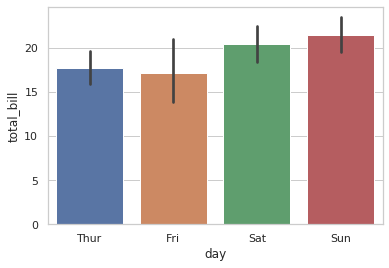

In [4]:
import seaborn as sns
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.barplot(x="day", y="total_bill", data=tips)

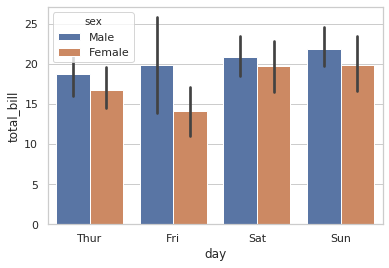

In [5]:
ax = sns.barplot(x="day", y="total_bill", hue="sex", data=tips)

In [7]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [9]:
df2

NameError: name 'df2' is not defined

In [ ]:
ax = sns.barplot(x="tip", y="day", data=df2)

In [ ]:
ax = sns.barplot(x="day", y="total_bill", hue="sex", data=tips)


In [88]:
df2 = df.T

In [89]:
df2

,Positive,Neutral,Negative,Mixed
churchill,0.276516,0.523759,0.064977,0.134878
reagan,0.156849,0.811257,0.015465,0.016495
luther_king,0.343839,0.594401,0.005916,0.056180
bezos,0.527087,0.390241,0.015820,0.066992
gaiman,0.461380,0.235781,0.147436,0.155467


In [3]:
import seaborn as sns
titanic = sns.load_dataset("titanic")
sns.catplot(x="sex", y="survived", hue="class", kind="bar", data=titanic);

In [2]:
# Subindo os arquivos de audio para o bucket s3 criado
for audio_file in df_audio.filename.values:
    print(audio_file)
    s3.upload_file(audio_file, bucket_name,  audio_file)
    #boto3.resource('s3').ObjectAcl(bucket_name,audio_file).put(ACL='public-read')

  Using cached https://files.pythonhosted.org/packages/a8/76/220ba4420459d9c4c9c9587c6ce607bf56c25b3d3d2de62056efe482dadc/seaborn-0.9.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/94/7f/b535ec711cbcc3246abea4385d17e1b325d4c3404dd86f15fc4f3dba1dbb/scipy-1.3.1-cp37-cp37m-manylinux1_x86_64.whl


Bibliografia e Links
* Tutorial de reconhecimento de audio em Python https://realpython.com/python-speech-recognition/
* Tutorial de como baixar videos do Youtube usando linha de comando no Linux https://itsfoss.com/download-youtube-linux/
* Projeto Youtube-DL https://github.com/ytdl-org/youtube-dl/blob/master/README.md#readme
* Discurso “We Shall Fight on the Beaches” de Winston Churchill https://www.artofmanliness.com/we-shall-fight-on-the-beaches-by-winston-churchill/
* Discurso “Remarks at the Brandenburg Gate” de Ronald Regan https://www.artofmanliness.com/remarks-at-the-brandenburg-gate-by-ronald-regan/
* Discurso "I Have a Dream" de Martin Luther King https://kinginstitute.stanford.edu/king-papers/documents/i-have-dream-address-delivered-march-washington-jobs-and-freedom
* Discurso “What Matters More Than Your Talents” de Jeff Bezos https://jamesclear.com/great-speeches/what-matters-more-than-your-talents-by-jeff-bezos
* Discurso “Make Good Art” de Neil Gaiman https://jamesclear.com/great-speeches/make-good-art-by-neil-gaiman
* Tutorial de configuração de conta AWS e boto3 https://boto3.amazonaws.com/v1/documentation/api/latest/guide/quickstart.html#using-boto-3
* Tutorial de como lidar com Json no Python https://realpython.com/python-json/
* Curso de 'Natural Language Processing Fundamentals in Python' do DataCamp https://www.datacamp.com/courses/natural-language-processing-fundamentals-in-python